## All libraries for model

In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob
import cv2
import imutils 
import seaborn as sns
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model, Sequential
import keras
import tensorflow as tf
from tensorflow import keras

## Count images in the two folders: yes (Tumor) and no (Healthey)

In [2]:

root =  'G://brain_tumor_dataset'
dict_img = {}
for dir in os.listdir(root):
  dict_img[dir] = len(os.listdir(os.path.join(root, dir)))
dict_img 

{'no': 98, 'yes': 155}

In [3]:
class_names = ['No, this case have not tumor','Yes, this case have tumor']

with open('labels.txt', 'w') as f:
  f.write('\n'.join(class_names))

## Plot some MRI images for yes tumor and no tumor

Text(0.5, 1.0, 'No, this case have not tumor')

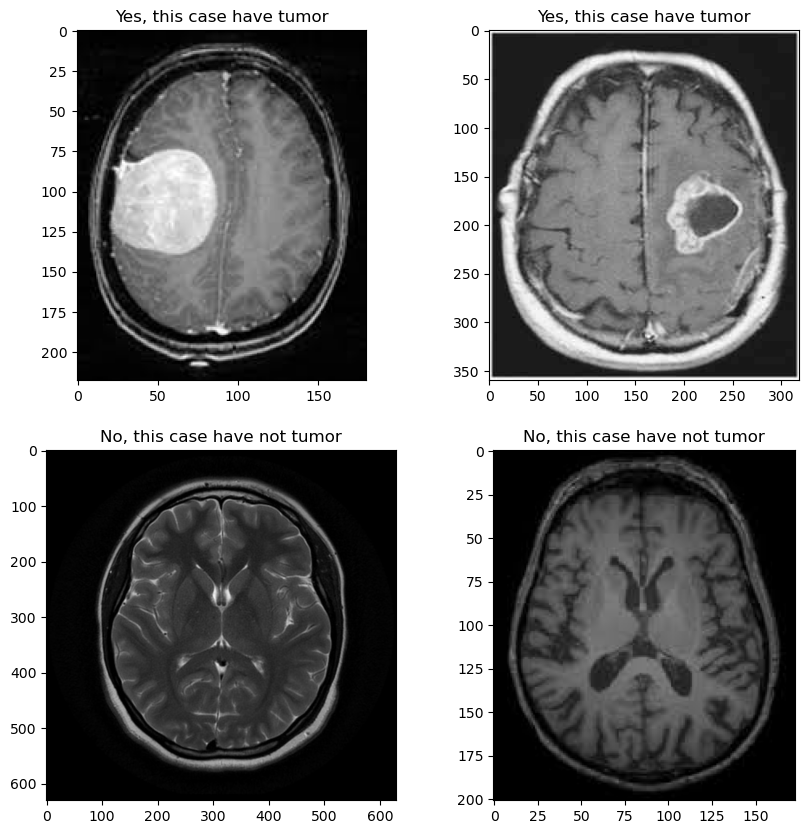

In [6]:


plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(load_img(os.path.join('G://brain_tumor_dataset//yes', os.listdir('G://brain_tumor_dataset//yes')[0])))
plt.title('Yes, this case have tumor')
plt.subplot(2, 2, 2)
plt.imshow(load_img(os.path.join('G://brain_tumor_dataset//yes', os.listdir('G://brain_tumor_dataset//yes')[1])))
plt.title('Yes, this case have tumor')

plt.subplot(2, 2, 3)
plt.imshow(load_img(os.path.join('G://brain_tumor_dataset//no', os.listdir('G://brain_tumor_dataset//no')[0])))
plt.title('No, this case have not tumor')
plt.subplot(2, 2, 4)
plt.imshow(load_img(os.path.join('G://brain_tumor_dataset//no', os.listdir('G://brain_tumor_dataset//no')[1])))
plt.title('No, this case have not tumor')

## Augmentation for data

In [7]:
# Define a function make augmentation for data

def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(
        rotation_range=10, 
        width_shift_range=0.1, 
        height_shift_range=0.1, 
        shear_range=0.1, 
        brightness_range=(0.3, 1.0),
        horizontal_flip=True, 
        vertical_flip=True, 
        fill_mode='nearest',
        rescale= 1/255
)

    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break
     


In [8]:
# I create augmented images folders at once
L = ['aug_train', 'aug_test', 'aug_val']
name = 'aug_data'
if not os.path.exists("./"+name):
  os.mkdir("./"+name)
  for dir in os.listdir(root):
    os.makedirs("./"+name+"/"+dir)
else:
  print(f"{name} Already exists")

aug_data Already exists


In [10]:

#Augment data for the examples with the label 'yes' in the training set
augment_data(file_dir='G://brain_tumor_dataset//yes',n_generated_samples=8, save_to_dir='./aug_data/yes')
#Augment data for the examples with the label 'no' in the training set
augment_data(file_dir='G://brain_tumor_dataset//no', n_generated_samples=12, save_to_dir='./aug_data/no')

In [11]:
# this Count images in the two folders: yes (Tumor) and no (Healthey) in the folder of augmented data images
root =  './aug_data/'
dict_img = {}
for dir in os.listdir(root):
  dict_img[dir] = len(os.listdir(os.path.join(root, dir)))
dict_img 

{'no': 1273, 'yes': 1394}

## Create some Folders for (Train, Test, Val)

In [9]:
# Define a function that creates new folders for the train, test and val sets and append random pictures to them based on the split percentage
def create_folders(name, perc):
  if not os.path.exists("./"+name):
    os.mkdir("./"+name)
    for dir in os.listdir(root):
      os.makedirs("./"+name+"/"+dir)
      for img in np.random.choice(a=os.listdir(os.path.join(root, dir)), size=(math.floor(perc*dict_img[dir])), replace=False):
        Src = os.path.join(root, dir, img)
        Dest = os.path.join("./"+name, dir)
        shutil.copy(Src, Dest)
        os.remove(Src)
  else:
    print(f"{name} Already exists")

In [10]:
#Create the training set
create_folders('train', 0.7)

train Already exists


In [11]:
#Create the test set
create_folders('test', 0.15)

test Already exists


In [12]:
#Create the validation set
create_folders('val', 0.15)

val Already exists


In [13]:
#Define a function that counts images in the folders: yes (Tumor) and no (Healthey)
def count_img(folder):
  dict_img = {}
  for dir in os.listdir(folder):
    dict_img[dir] = len(os.listdir(os.path.join(folder, dir)))
  return dict_img

In [14]:
#Count images in the training set for no and yes tumor
count_img('train')

{'no': 891, 'yes': 976}

In [15]:
#Count images in the test set for no and yes tumor
count_img('test')

{'no': 191, 'yes': 209}

In [16]:
#Count images in the val set for no and yes tumor
count_img('val')

{'no': 191, 'yes': 209}

## Image Processing

In [17]:
####### I work here image processing to Crop images when i detection.

#Define a function that crop tha brain tumors
def crop_brain_tumor(image, plot):
    
    #Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    #Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    #This Extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    #Crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

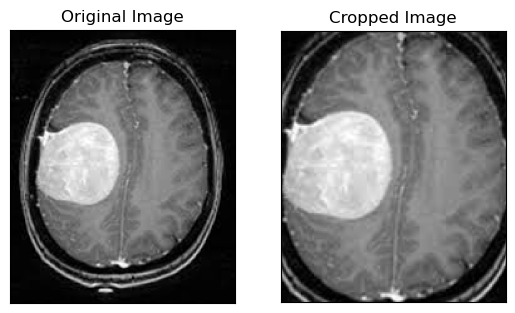

In [18]:
# Practice about original image and cropped image.

pract_img= cv2.imread('G://brain_tumor_dataset//yes//Y1.jpg')
img=crop_brain_tumor(pract_img, plot=True)


## Load and Training data for all images

In [19]:
#Define a function that load data
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    
    
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_tumor(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of load images is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [20]:
#Load trainig data
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_train, y_train = load_data(['./train/yes', './train/no'], (IMG_WIDTH, IMG_HEIGHT))

Number of load images is: 1867
X shape is: (1867, 240, 240, 3)
y shape is: (1867, 1)


In [22]:
#Define a function that plot images
def plot_sample_images(X, y, n=50):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes, this case have tumor " if label == 1 else "No, this case have not tumor"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

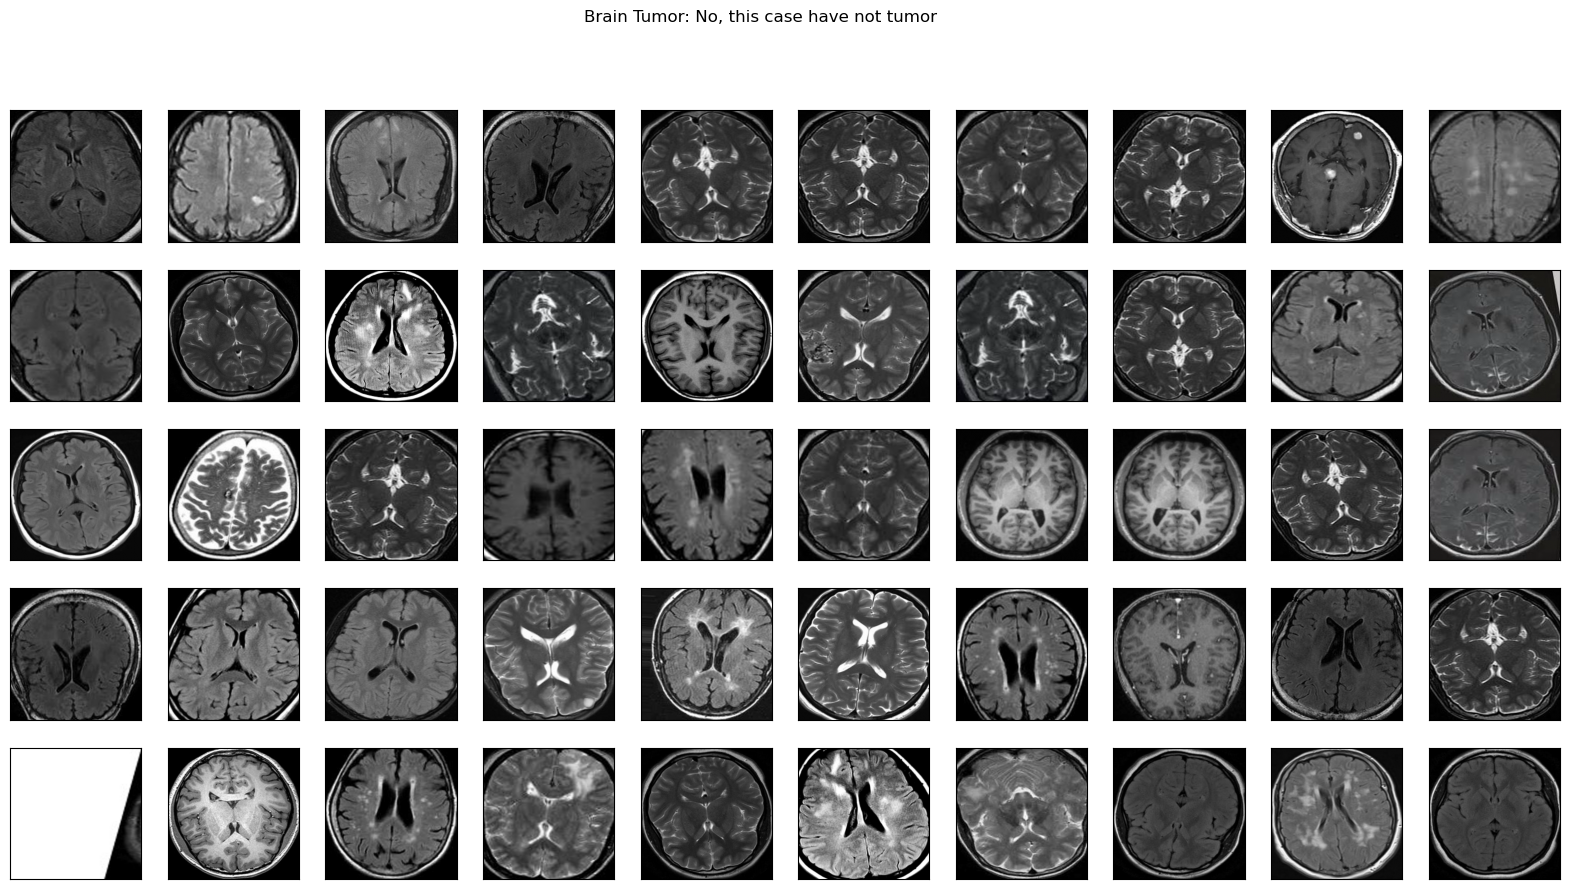

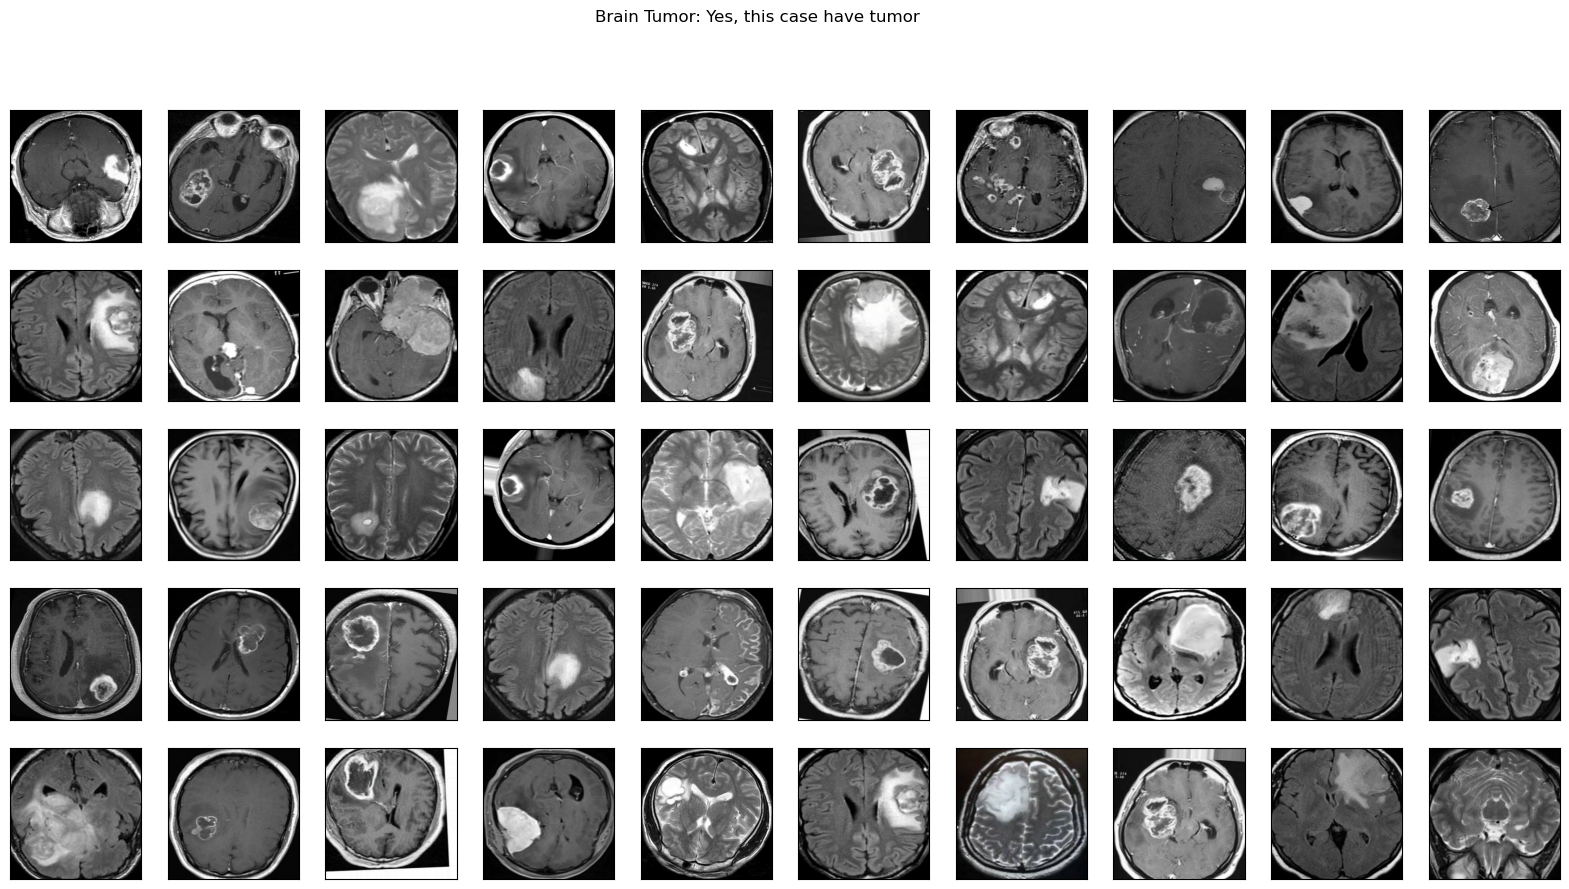

In [23]:
#Plot samples from the training set
plot_sample_images(X_train, y_train)

In [24]:
#Load test data
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_test, y_test = load_data(['./test/yes', './test/no'], (IMG_WIDTH, IMG_HEIGHT))

Number of load images is: 400
X shape is: (400, 240, 240, 3)
y shape is: (400, 1)


In [25]:
#Load validation data
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_val, y_val = load_data(['./val/yes', './val/no'], (IMG_WIDTH, IMG_HEIGHT))

Number of load images is: 400
X shape is: (400, 240, 240, 3)
y shape is: (400, 1)


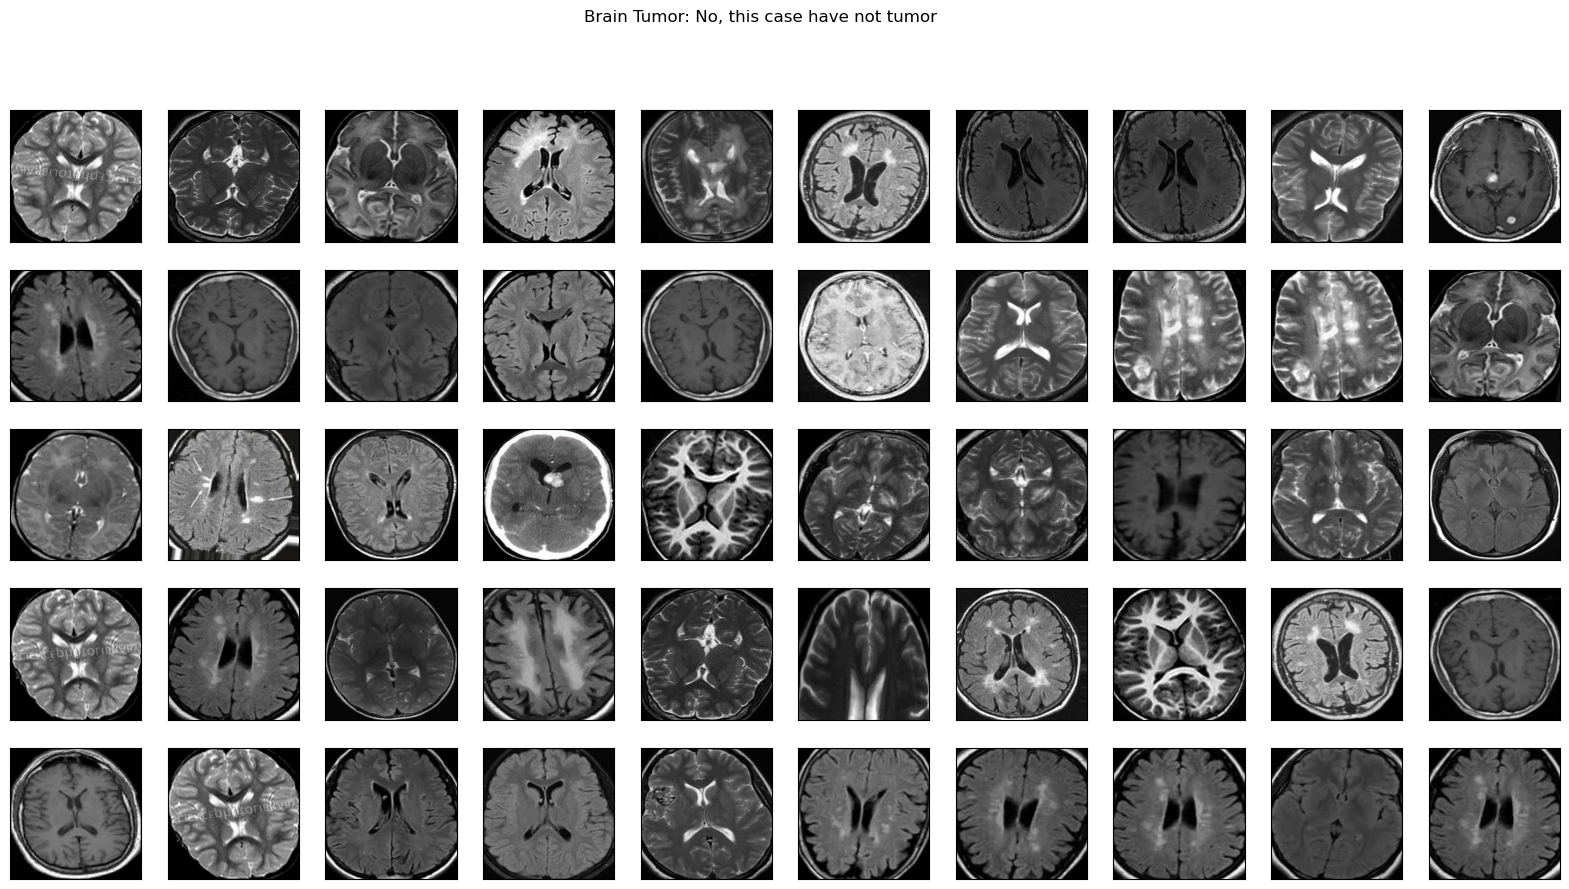

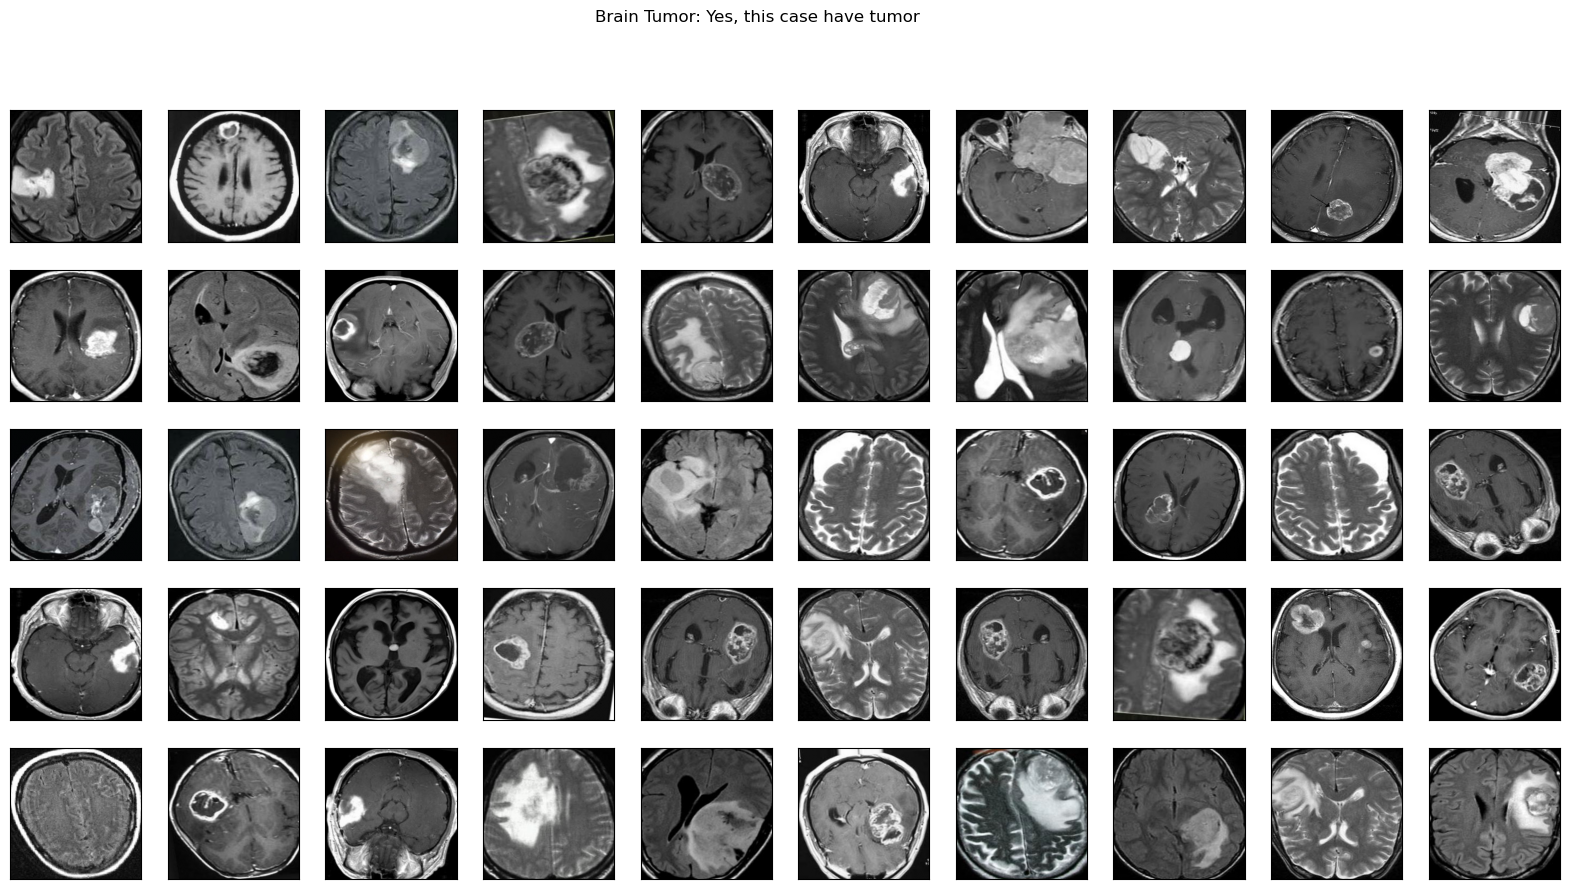

In [26]:
#Plot samples from the validation set
plot_sample_images(X_val, y_val)

## CNN Model

In [27]:
##### CNN model

#Build our model
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = (240, 240, 3)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Dropout(rate = 0.25))

model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.25)) 
model.add(Dense(units = 1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 238, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 236, 236, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 118, 118, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 116, 116, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 58, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 128)       7

## Training Data

In [44]:
#Compile our model
model.compile(optimizer = 'adam', loss = keras.losses.binary_crossentropy, metrics = ['accuracy'])

In [45]:
#Early stopping and model checkpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping 

# this statement check validation of accuracy 
early_stop = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
model_check = ModelCheckpoint(monitor ='val_accuracy', filepath = './bestmodel.h5', verbose = 1, save_best_only = True, mode = 'auto')
# early_stop = EarlyStopping(monitor = 'val_accuracy', verbose = 1, mode = 'auto')
# model_chek =ModelCheckpoint(monitor = 'val_accuracy',  filepath = './bestmodel.h5', verbose = 1, mode = 'auto')



In [46]:
#Train our models

hist_to_train = model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 10,validation_data = (X_val, y_val), callbacks = [early_stop,model_check])
#  validation_data = (X_val, y_val), callbacks = [early_stop, model_check]

Epoch 1/10
59/59 [==============================] - ETA: 0s - loss: 0.5546 - accuracy: 0.7295
Epoch 1: val_accuracy improved from -inf to 0.77750, saving model to .\bestmodel.h5
59/59 [==============================] - 432s 6s/step - loss: 0.5546 - accuracy: 0.7295 - val_loss: 0.4711 - val_accuracy: 0.7775
Epoch 2/10
59/59 [==============================] - ETA: 0s - loss: 0.4536 - accuracy: 0.7991
Epoch 2: val_accuracy did not improve from 0.77750
59/59 [==============================] - 281s 5s/step - loss: 0.4536 - accuracy: 0.7991 - val_loss: 0.4749 - val_accuracy: 0.7500
Epoch 3/10
59/59 [==============================] - ETA: 0s - loss: 0.4075 - accuracy: 0.8163
Epoch 3: val_accuracy improved from 0.77750 to 0.80750, saving model to .\bestmodel.h5
59/59 [==============================] - 277s 5s/step - loss: 0.4075 - accuracy: 0.8163 - val_loss: 0.4128 - val_accuracy: 0.8075
Epoch 4/10
59/59 [==============================] - ETA: 0s - loss: 0.3425 - accuracy: 0.8511
Epoch 4: val

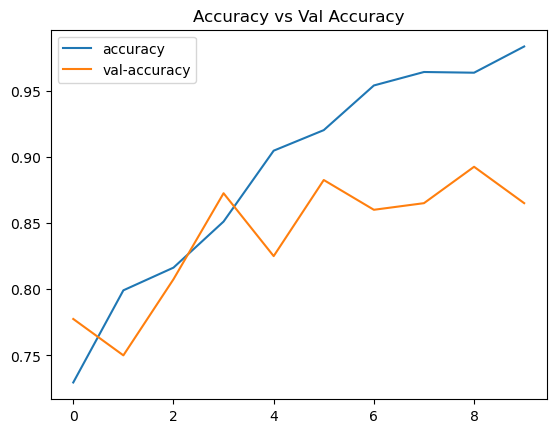

In [47]:
#Plot the graphical interpretation
# this garaph to clear a relative between Accuracy and Val Accuracy
h = hist_to_train.history
plt.plot(h['accuracy'], label = 'accuracy')
plt.plot(h['val_accuracy'], label = 'val-accuracy')
plt.title('Accuracy vs Val Accuracy')
plt.legend()


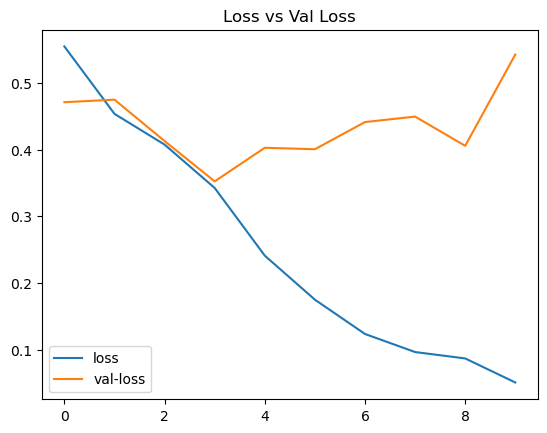

In [48]:
#Plot the graphical interpretation
# this garaph to clear a relative between Loss and Val Loss
h = hist_to_train.history
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val-loss')
plt.title('Loss vs Val Loss')
plt.legend()
plt.show()

In [49]:
#Test our model on the test set

from keras.models import load_model
model = load_model('./bestmodel.h5')
acc = model.evaluate(X_test, y_test)[1]
print(f'The accuracy of our model is {(int)(acc*100)} %')
#print(f"Accuracy on Evaluation: {acc[1]*100:.2f}%\nLoss: {acc[0]:.4f}")

13/13 [==============================] - 17s 1s/step - loss: 0.3562 - accuracy: 0.8800
The accuracy of our model is 87 %


## Transfer Learning data Model

In [50]:
##### Transfer Learing

#Import MobileNet Model
from keras.applications.mobilenet import MobileNet
base_model = MobileNet(input_shape=(240,240,3), include_top=False)

In [51]:
#Make the layers of the model untrainable
for layer in base_model.layers:
  layer.trainable = False

In [52]:
#Add a flatten and dense layers to the base model
X = Flatten()(base_model.output)
X = Dense(units=1, activation='sigmoid')(X)
transfer_model = Model(base_model.input, X)



In [53]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 120, 120, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 120, 120, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 120, 120, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 120, 120, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 120, 120, 32)     128       
 ation)                                                      

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 15, 15, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 15, 15, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 15, 15, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 15, 15, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 15, 15, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 15, 15, 512)       262144    
                                                                 
 conv_pw_9

## Training data after Transfer Learning Model

In [54]:
#Compile the new model after transfer learing
transfer_model.compile(optimizer='rmsprop', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [55]:
#Early stopping and model checkpoint
early_stop_trans = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
model_check_trans = ModelCheckpoint(monitor ='val_accuracy', filepath = './besttransfermodel.h5', verbose = 1, save_best_only = True, mode = 'auto')



In [56]:
#Fit our new model after transfer learing
transfer_hist = transfer_model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 10, validation_data = (X_val, y_val),callbacks = [early_stop_trans, model_check_trans]) 
# validation_data = (X_val, y_val), callbacks = [early_stop_trans, model_check_trans],

Epoch 1/10
59/59 [==============================] - ETA: 0s - loss: 2.6347 - accuracy: 0.8211
Epoch 1: val_accuracy improved from -inf to 0.69750, saving model to .\besttransfermodel.h5
59/59 [==============================] - 157s 2s/step - loss: 2.6347 - accuracy: 0.8211 - val_loss: 2.1819 - val_accuracy: 0.6975
Epoch 2/10
59/59 [==============================] - ETA: 0s - loss: 0.5395 - accuracy: 0.9357
Epoch 2: val_accuracy improved from 0.69750 to 0.98250, saving model to .\besttransfermodel.h5
59/59 [==============================] - 114s 2s/step - loss: 0.5395 - accuracy: 0.9357 - val_loss: 0.0897 - val_accuracy: 0.9825
Epoch 3/10
59/59 [==============================] - ETA: 0s - loss: 0.3555 - accuracy: 0.9646
Epoch 3: val_accuracy did not improve from 0.98250
59/59 [==============================] - 105s 2s/step - loss: 0.3555 - accuracy: 0.9646 - val_loss: 0.6461 - val_accuracy: 0.9075
Epoch 4/10
59/59 [==============================] - ETA: 0s - loss: 0.3043 - accuracy: 0.9

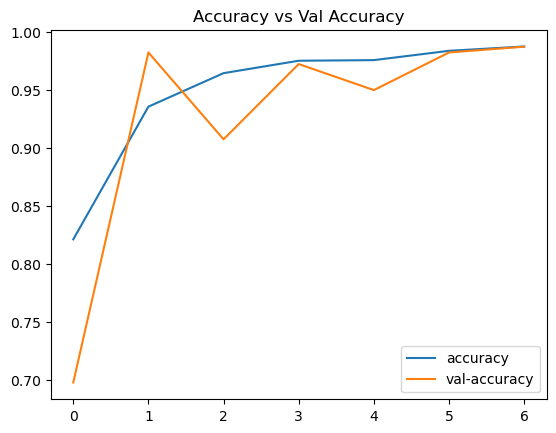

In [57]:
#Plot the graphical interpretation
# after when we do transfer learing to training the data measuring to two relation
h = transfer_hist.history
plt.plot(h['accuracy'], label = 'accuracy')
plt.plot(h['val_accuracy'], label = 'val-accuracy')
plt.title('Accuracy vs Val Accuracy')
plt.legend()
plt.show()

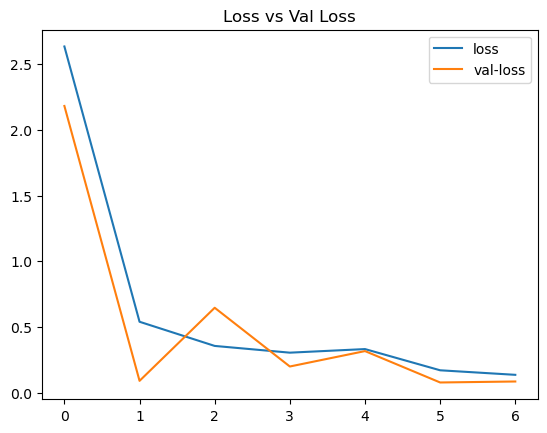

In [58]:
#Plot the graphical interpretation
## after when we do transfer learing to training the data measuring to two relation
h = transfer_hist.history
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val-loss')
plt.title('Loss vs Val Loss')
plt.legend()
plt.show()

In [60]:
#Test our model on the test set
# after when we do transfer learing to training the data so i know accuracy in model
from keras.models import load_model
model = load_model('./besttransfermodel.h5')
acc = model.evaluate(X_test, y_test)[1]
print(f'The accuracy of our model is {(int) (acc *100)} %')


13/13 [==============================] - 19s 1s/step - loss: 0.0280 - accuracy: 0.9925
The accuracy of our model is 99 %


## Save Model as Tensorflow lite

In [ ]:
saved_model_dir = 'Brain_Tumor_Model' #means current directory

tf.saved_model.save(model, saved_model_dir) #saves to the current directory

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) 
tflite_model = converter.convert() #converts our model into a .tflite model which flutter uses for ondevice machine learning

with open('model_brain_tumour.tflite', 'wb') as f: #to write the converted model into a file, written as binary so add 'wb' instead of 'w'
  f.write(tflite_model)


INFO:tensorflow:Assets written to: Brain_Tumor_Model\assets


INFO:tensorflow:Assets written to: Brain_Tumor_Model\assets
